# 04wk-1: 깊은신경망 (2) – 꺽인그래프의 한계?, 시벤코정리, MNIST

최규빈  
2024-03-20

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/03wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-y4BW27vnVa08AtMixu1IwL&si=v_BjoNGj2eVBht3Z>

# 2. Imports

In [944]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
#from fastai.data.all import * 
#import torchvision
#import pathlib

# 3. 꺽인그래프의 한계?

`-` 걱정: 언뜻 생각하면 방금 배운 기술은 sig를 취하기 전이 꺽은선인
형태만 가능할 듯 하다. 그래서 이 역시 표현력이 부족할 듯 하다.

`-` 그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다.

## A. Step은 표현 불가능하지 않나?

`-` 맞춰봐

In [945]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]
sig = torch.nn.Sigmoid()
v = π = sig(u)
y = torch.bernoulli(v)

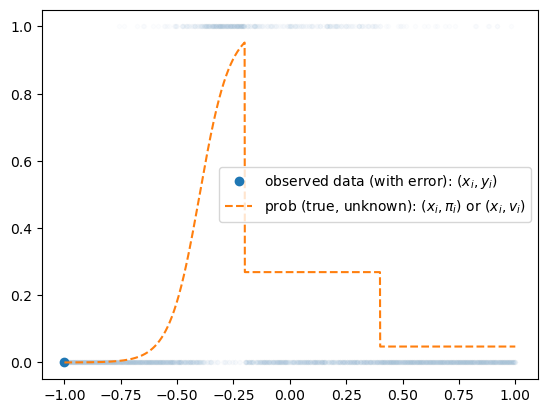

In [946]:
#plt.plot(u,alpha=0.2)
plt.plot(x,y,'.',alpha=0.01,color="C0")
plt.plot(x[0],y[0],'o',color="C0",label=r"observed data (with error): $(x_i,y_i)$")
plt.plot(x,v,'--',label=r"prob (true, unknown): $(x_i,\pi_i)$ or $(x_i,v_i)$",color="C1")
plt.legend()

`-` 선이 많이 꺽이면되는거아냐?

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [947]:
#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,1),
    #torch.nn.Sigmoid()
)
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

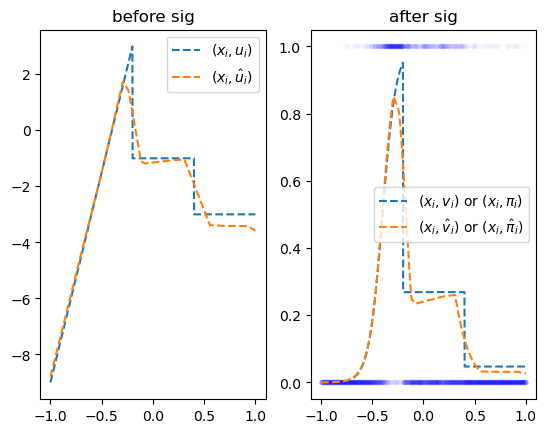

In [948]:
fig,ax = plt.subplots(1,2)
ax[0].plot(x,u,'--',label=r"$(x_i,u_i)$")
ax[0].plot(x,yhat.data,'--',label=r"$(x_i,\hat{u}_i)$")
ax[0].legend()
ax[0].set_title("before sig")
ax[1].plot(x,y,'.',alpha=0.02,color="blue")
ax[1].plot(x,v,'--', color="C0", label=r"$(x_i,v_i)$ or $(x_i,\pi_i)$")
ax[1].plot(x,sig(yhat.data),'--',color="C1",label=r"$(x_i,\hat{v}_i)$ or $(x_i,\hat{\pi}_i)$")
ax[1].legend()
ax[1].set_title("after sig")

## B. 곡선은 표현 불가능하지 않나?

`-` 맞춰봐[1]

$$y_i = e^{-x_i} \times  |\cos(5x_i)| \times \sin(5x) + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma^2)$$

[1] 2024년 수능 미적30번 문제에 나온 함수응용

In [949]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

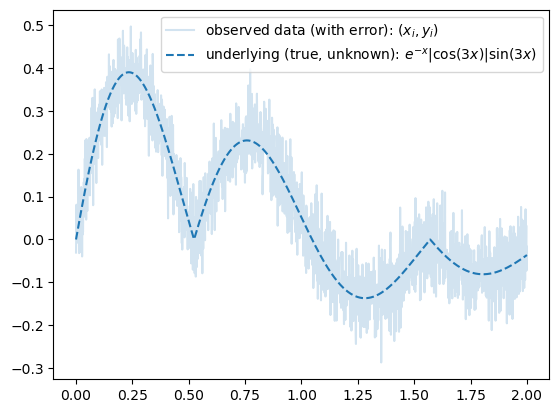

In [950]:
plt.plot(x,y,label=r"observed data (with error): $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unknown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.legend()

`-` 맞춰본다..

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1024)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,1024)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [951]:
#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

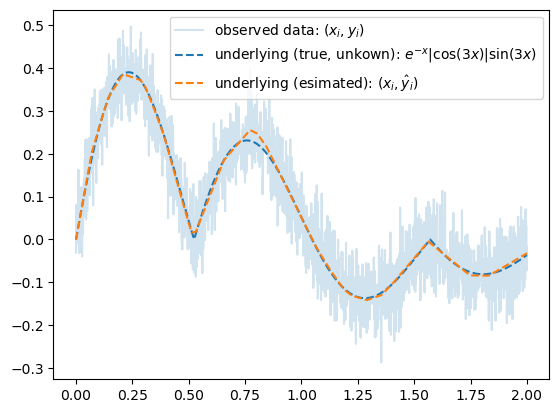

In [952]:
plt.plot(x,y,label=r"observed data: $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unkown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.plot(x,yhat.data,'--',color="C1",label=r"underlying (esimated): $(x_i,\hat{y}_i)$")
plt.legend()

# 4. 시벤코정리

## A. 시벤코의 정리 소개

> **Universal Approximation Thm:
> (범용근사정리,보편근사정리,시벤코정리)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크는
>
> ``` python
> torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 continuous
> mapping $f$ 을 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 심층신경망(DNN)이 원하는 정확도로 근사시킨다는 의미이다. 예를들면
> 심층신경망은 아래와 같은 문제를 해결할 수 있다.
>
> -   ${\bf X}$는 토익점수, GPA, 공모전참가여부, ${\bf y}$는 취업여부일
>     경우 ${\bf X} \to {\bf y}$인 규칙을 심층신경망은 항상 찾을 수
>     있다.
> -   ${\bf X}$는 주택이미지, 지역정보, 주택면적, 주택에 대한 설명
>     ${\bf y}$는 주택가격일 경우 ${\bf X} \to {\bf y}$인 규칙을
>     심층신경망은 항상 찾을 수 있다.
>
> 즉 하나의 은닉층을 가진 심층신경망 모델의 표현력은 무한대라 볼 수
> 있다.

## B. 왜 가능한가?

`-` 데이터

In [953]:
x = torch.linspace(-10,10,200).reshape(-1,1)

`-` 아래와 같은 네트워크를 고려하자.

In [954]:
l1 = torch.nn.Linear(in_features=1,out_features=2)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=2,out_features=1)

`-` 직관1: $l_1$,$l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이
만들 수 있다.

In [955]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [956]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

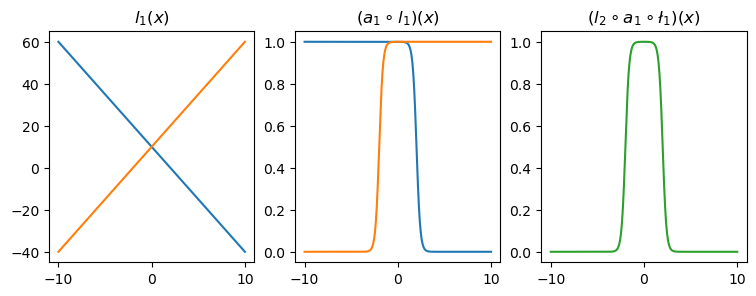

In [973]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,np.array(l1(x).data)); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,np.array(a1(l1(x)).data)); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,color='C2'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')

`-` 직관2: 아래들도 가능할듯?

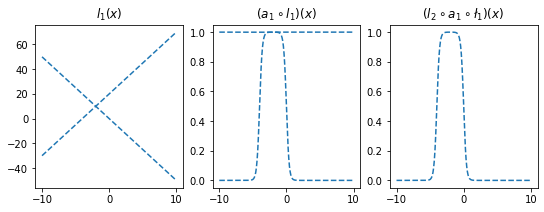

In [20]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data,'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');

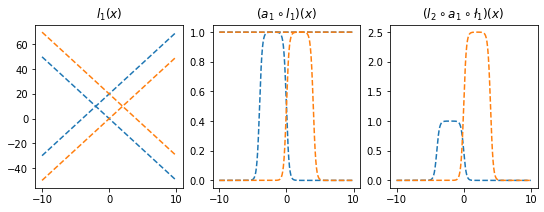

In [21]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+0.00])
l2.weight.data = torch.tensor([[2.50,2.50]])
l2.bias.data = torch.tensor([-2.50])
ax[0].plot(x,l1(x).data,'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
fig

`-` `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [22]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [23]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

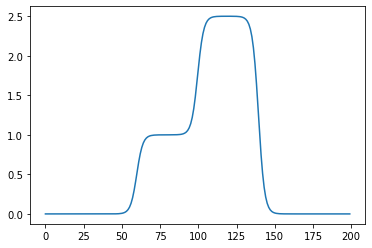

In [24]:
plt.plot(l2(a1(l1(x))).data)

`-` 직관: 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은 함수 $h$를
만들 수 있다.

In [978]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0

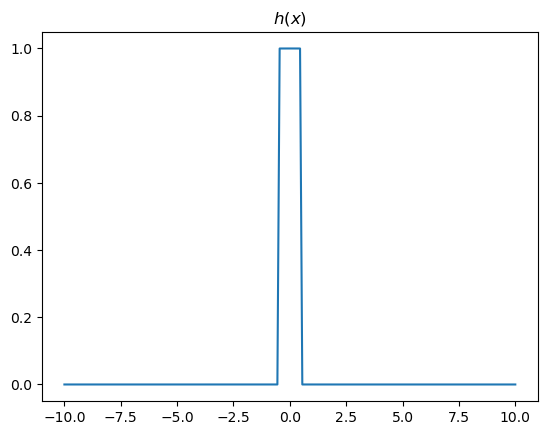

In [979]:
plt.plot(x,h(x))
plt.title("$h(x)$")

`-` 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 전체 네트워크를 아래와
같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 이 네트워크는 어떠한 함수형태라도 구불구불한 step의 형태로 다 맞출수
있다.

## C. $h$의 위력

`-` $h(x)$를 활성화함수로 가지는 네트워크를 설계하여 보자.

In [1012]:
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) # activation 의 출력 

In [1013]:
a1 = MyActivation()
# a1 = torch.nn.Sigmoid(), a1 = torch.nn.ReLU() 대신에 a1 = MyActivation()

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` $h$의 위력

**예제1** – 스펙높아도 취업이 안된다고??

In [1014]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

In [1015]:
torch.manual_seed(43052)
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 
#---# 
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters()) 
#---#
for epoc in range(100):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

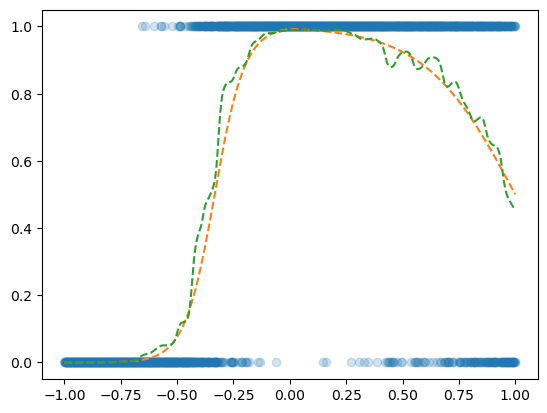

In [1016]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(x,prob,'--')
plt.plot(x,net(x).data,'--')

**예제2** – 수능에 나왔다던 이상한 곡선..?

In [1020]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

In [1021]:
torch.manual_seed(43052)
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 
#---# 
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters()) 
#---#
for epoc in range(100):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

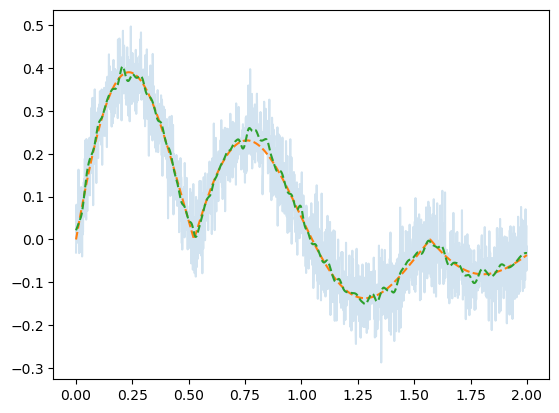

In [1024]:
plt.plot(x,y,alpha=0.2)
plt.plot(x,fx,'--')
plt.plot(x,net(x).data,'--')

## D. 의문점

`-` 이 수업을 잘 이해한 사람: 그냥 활성화함수를 $h$로 쓰면 끝 아니야?
뭐하러 relu 를 쓰는거지?

`-` 딥러닝을 좀 공부해본사람1: 왜 딥러닝이 2010년이 지나서야 떳지?
1989년에 세상의 모든 문제가 풀려야 하는것 아닌가?

`-` 딥러닝을 좀 공부해본사람2: 하나의 은닉층을 표현하는 네크워크는 잘
안쓰지 않나? 은닉층이 많을수록 좋다고 들었는데?

`-` 약간의 의구심이 있지만 아무튼 우리는 아래의 무기를 가진 꼴이 되었다.

> **우리의 무기**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크로,
>
> ``` python
> torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 continuous
> mapping $f$ 을 원하는 정확도로 “근사”시킬 수 있다.

# 5. MNIST 해결

## A. 데이터 다운로드

In [641]:
untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')

In [700]:
!ls '/home/cgb3/.fastai/data/mnist_png'

testing  training

In [701]:
!ls '/home/cgb3/.fastai/data/mnist_png/training/'

0  1  2  3  4  5  6  7  8  9

In [702]:
!ls '/home/cgb3/.fastai/data/mnist_png/training/3' | head

10.png
10000.png
10011.png
10031.png
10034.png
10042.png
10052.png
1007.png
10074.png
10091.png
ls: write error: Broken pipe

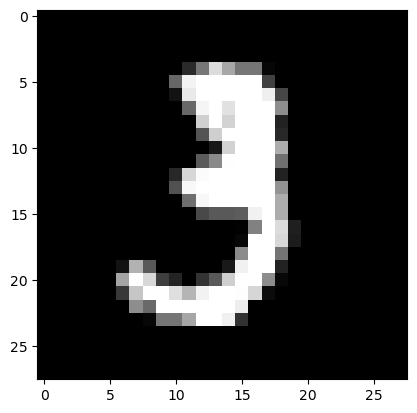

In [699]:
img3 = torchvision.io.read_image('/home/cgb3/.fastai/data/mnist_png/training/3/10.png')
plt.imshow(img3.reshape(28,28),cmap="gray")

## B. 예비학습 – \``plt.imshow()`

`-` `plt.imshow(...)` 에서 `...`이 shape이 (??,??)이면 흑백이미지를 출력

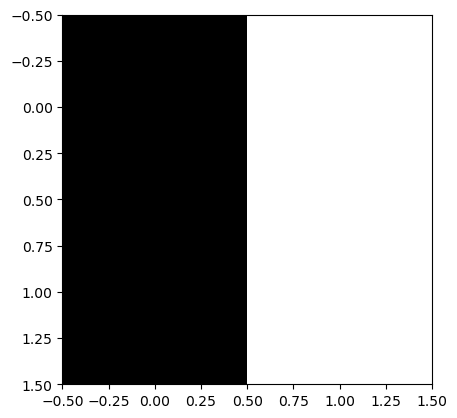

In [716]:
plt.imshow([[0,255],[0,255]],cmap='gray')

`-` `plt.imshow(...)` 에서 `...`의 shape이 (??,??,3)이면 칼라이미지를
출력

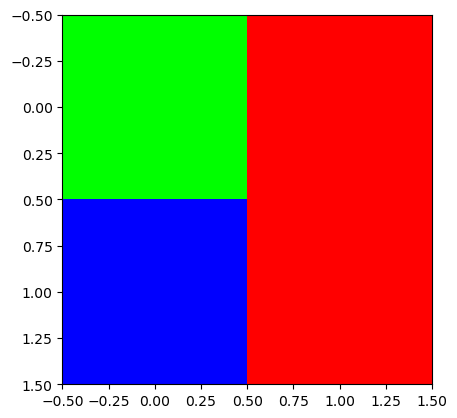

In [721]:
r = [[0,255],[0,255]]
g = [[255,0],[0,0]]
b = [[0,0],[255,0]]
plt.imshow(np.stack([r,g,b],axis=2))

`-` `plt.imshow(...)` 에서 `...`의 자료형이 int인지 float인지에 따라서
인식이 다름

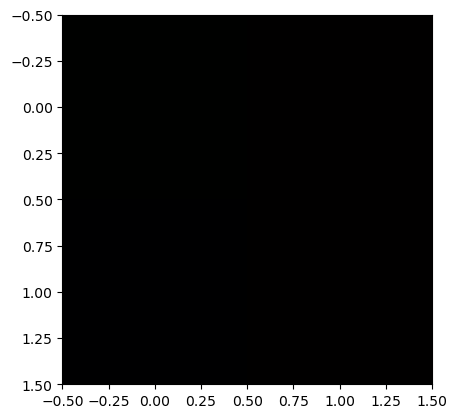

In [734]:
r = [[0,1],[0,1]]
g = [[1,0],[0,0]]
b = [[0,0],[1,0]]
plt.imshow(np.stack([r,g,b],axis=2))

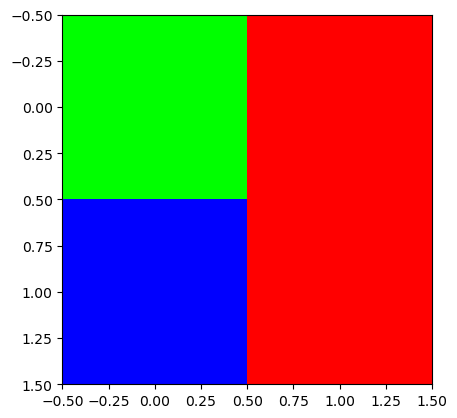

In [731]:
r = [[0,1.0],[0,1.0]]
g = [[1.0,0],[0,0]]
b = [[0,0],[1.0,0]]
plt.imshow(np.stack([r,g,b],axis=2))

## C. 예비학습 – pathlib

In [664]:
import pathlib

`-` 오브젝트 생성

In [725]:
path = pathlib.Path('.')
path

`-` 기능1 – `.ls()`

In [724]:
path.ls()

`-` 이미지 파일이 저장된 경로로 새로운 `path`오브젝트를 만들고 기능1
수행

In [741]:
path = pathlib.Path('/home/cgb3/.fastai/data/mnist_png')
path

In [743]:
path.ls()

`-` 기능2: `/` 로 새로운 path 생성하기

In [746]:
(path / 'training')

`-` 기능1,2의 결합

In [753]:
(path / 'training').ls()

## D. 데이터정리

`-` 데이터가 저장된 path 설정

In [864]:
path = pathlib.Path('/home/cgb3/.fastai/data/mnist_png')

`-` `X` ,`y`를 만듦

In [865]:
X3 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'training/3').ls()],axis=0)
X7 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'training/7').ls()],axis=0)

In [866]:
X3.shape, X7.shape

In [867]:
y = torch.tensor([0.0]*6131+[1.0]*6265).reshape(-1,1)

In [868]:
X = torch.concat([X3,X7],axis=0)
X.shape

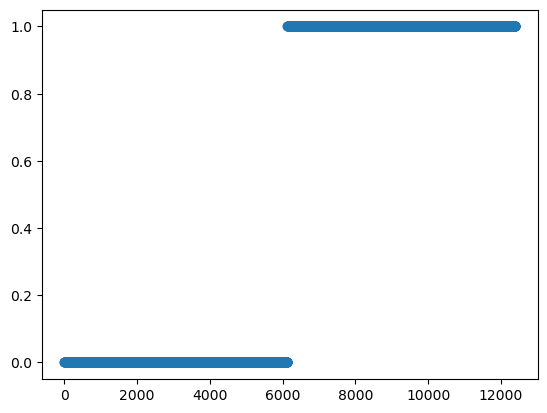

In [869]:
plt.plot(y,'o')

-   “y=0.0” 은 숫자3을 의미함, “y=1.0” 은 숫자7을 의미함
-   숫자3은 6131개, 숫자7은 6265개 있음

`-` 우리는 ${\bf X}: (n,1,28,28)$ 에서 ${\bf y}: (n,1)$으로 가는 맵핑을
배우고 싶음. $\to$ 이런건 배운적이 없는데?.. $\to$ 그렇다면
${\bf X}:(n,784) \to {\bf y}:(n,1)$ 으로 가는 맵핑을 학습하자.

In [871]:
Xnp = X.reshape(-1,28*28).float()
X.shape, Xnp.shape

## E. 학습

In [873]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(200):
    ## step1 
    yhat = net(Xnp) 
    ## step2
    loss = loss_fn(yhat,y)
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

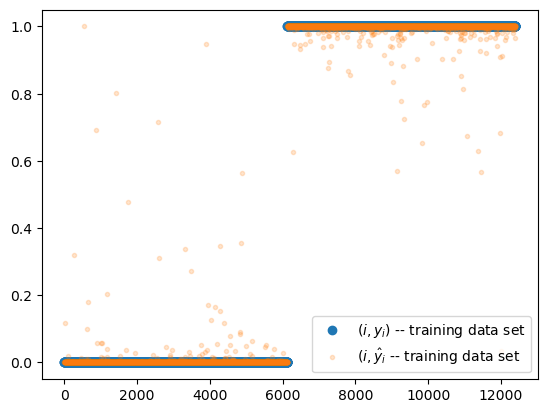

In [921]:
plt.plot(y,'o',label=r"$(i,y_i)$ -- training data set")
plt.plot(net(Xnp).data,'.',alpha=0.2, label=r"$(i,\hat{y}_i$ -- training data set")
plt.legend()

-   잘맞추는데?
-   믿을수가 없는데..?

In [941]:
((yhat.data > 0.5) == y).float().mean() # train_accuracy

## F. Test

In [928]:
path.ls()

In [929]:
XX3 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'testing/3').ls()],axis=0)
XX7 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'testing/7').ls()],axis=0)

In [930]:
XX3.shape,XX7.shape

In [931]:
XX = torch.concatenate([XX3,XX7],axis=0).reshape(-1,1*28*28).float()
XX.shape

In [932]:
yy = torch.tensor([0]*1010 + [1]*1028).reshape(-1,1).float()
yy.shape

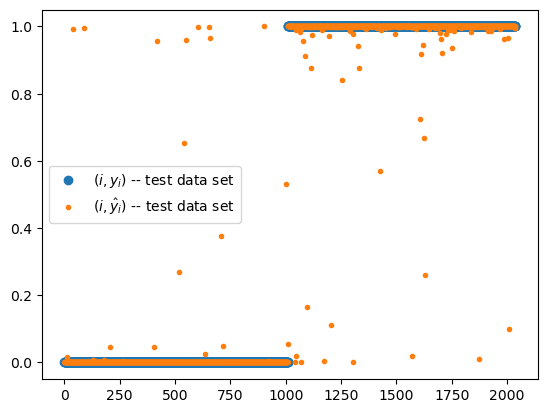

In [933]:
plt.plot(yy,'o',label=r"$(i,y_i)$ -- test data set")
plt.plot(net(XX).data,'.',label=r"$(i,\hat{y}_i)$ -- test data set")
plt.legend()

In [940]:
(yy == (net(XX)>0.5)).float().mean() # test accuracy

-   test 에서도 잘 맞춘다..